In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import time

## Model Configuration

In [2]:
from dataclasses import dataclass
from typing import Optional

@dataclass
class ModelArgs:
    dim: int = 128
    n_layers: int = 2
    n_heads: int = 4
    n_kv_heads: Optional[int] = None
    vocab_size: int = -1  # defined later by tokenizer
    multiple_of: int = 256  # make SwiGLU hidden layer size multiple of large power of 2
    ffn_dim_multiplier: Optional[float] = None
    norm_eps: float = 1e-5

    max_batch_size: int = 32
    max_seq_len: int = 16 * 8

    epochs: int = 5_000    

model_config = ModelArgs()
print(model_config)

ModelArgs(dim=128, n_layers=2, n_heads=4, n_kv_heads=None, vocab_size=-1, multiple_of=256, ffn_dim_multiplier=None, norm_eps=1e-05, max_batch_size=32, max_seq_len=128, epochs=5000)


## Prepare Data

In [3]:
# simple tokenization by characters
def encode(s):
    return [stoi[ch] for ch in s]

def decode(l):
    return ''.join([itos[i] for i in l])


lines = open('./data/Shakespeare.txt', 'r').read()
vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}
dataset = torch.tensor(encode(lines), dtype=torch.int8)
print(f'Sentences: {dataset.shape[0]}')

model_config.vocab_size = len(vocab)

def get_batches(data, split, batch_size, context_window):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    if split == 'train':
        batch_data = train
    elif split == 'test':
        batch_data = test
    else:
        batch_data = val

    # pick random starting points
    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i+context_window] for i in ix]).long()
    y = torch.stack([batch_data[i+1:i+context_window+1] for i in ix]).long()
    return x, y

Sentences: 1115394


## Define Models

### RMS Normalization 

- [Paper](https://arxiv.org/pdf/1910.07467.pdf)
- [Reference implementation](https://github.com/facebookresearch/llama/blob/54d44631054deae836aec8ceff92dcf8f20ca9e7/llama/model.py#L34)

In [4]:
class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """
        Initialize the RMSNorm normalization layer.

        Args:
            dim (int): The dimension of the input tensor.
            eps (float, optional): A small value added to the denominator for numerical stability. Default is 1e-6.

        Attributes:
            eps (float): A small value added to the denominator for numerical stability.
            weight (nn.Parameter): Learnable scaling parameter.

        """
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x : torch.tensor) -> torch.tensor:
        """
        Apply the RMSNorm normalization to the input tensor.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The normalized tensor.

        """
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x) -> torch.tensor:
        """
        Forward pass through the RMSNorm layer.

        Args:
            x (torch.Tensor): The input tensor.

        Returns:
            torch.Tensor: The output tensor after applying RMSNorm.

        """        
        return self._norm(x.float()).type_as(x) * self.weight

### RoPE

- [Paper](https://arxiv.org/pdf/2104.09864.pdf)
- [Reference Implementation](https://github.com/facebookresearch/llama/blob/dccf644213a2771a81fc4a754eed9623ea7f8444/llama/model.py#L80)

In [5]:
class RoPE:
    def __init__(self, dim: int, max_seq_len: int, theta: float = 10000.0):
        """
        Precompute the frequency tensor for complex exponentials (cis, defined as 'm*theta_i' in the paper) 
        with given dimensions.

        Calculates a frequency tensor with complex exponentials using the given dimension 'dim'
        and the max sequence length. The 'theta_base' parameter scales the frequencies.
        The returned tensor contains complex values in complex64 data type.

        Args:
            dim (int): Dimension of the frequency tensor.
            max_seq_len (int): Max sequence length.
            theta_base (float, optional): Scaling factor for frequency computation. Defaults to 10000.0.
        """
        freqs = 1.0 / (theta ** (torch.arange(0, dim, 2)[: (dim // 2)].float() / dim))
        freqs = torch.outer(torch.arange(max_seq_len), freqs).float()
        self.freqs_cis = torch.polar(torch.ones_like(freqs), freqs)  # complex64
        print(f'Initialized RoPE with shape {self.freqs_cis.shape}')
        
    def __call__(self, x: torch.Tensor, start_pos = 0) -> torch.Tensor:
        """
        Apply rotary embeddings to input tensors using the given frequency tensor.

        This function first reshapes the frequency tensor to have the same shape as the target tensor 'x'
        for the purpose of broadcasting the frequency tensor during element-wise operations. Then, it applies 
        rotary embeddings to 'x' tensor using frequency tensor 'freqs_cis'.         
        """
        x_complex = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))

        shape = [d if i == 1 or i == x.ndim - 1 else 1 for i, d in enumerate(x_complex.shape)]
        freqs_cis = self.freqs_cis[start_pos:start_pos + x.shape[-2]].view(*shape)
                
        x_real = torch.view_as_real(x_complex * freqs_cis).flatten(-2)
        
        return x_real.type_as(x)

#### RoPE Test

In [6]:
dim = 128
max_seq_len = 256

def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim//2):
            theta = 10000. ** (-2.*i / embedding_dim)
            m_theta = position * theta
            R[position, 2*i,2*i] = np.cos(m_theta)
            R[position, 2*i,2*i+1] = - np.sin(m_theta)
            R[position, 2*i+1,2*i] = np.sin(m_theta)
            R[position, 2*i+1,2*i+1] = np.cos(m_theta)
    return R

R = get_rotary_matrix(max_seq_len, dim)

X= torch.ones(1, max_seq_len, dim)
rope = RoPE(dim=dim, max_seq_len=max_seq_len)
X1 = rope(X)
X2 = (R @ X.unsqueeze(-1)).flatten(-2)

print(X1.allclose(X2, atol=1e-3))


Initialized RoPE with shape torch.Size([256, 64])
True


### Attention

In [7]:
class Attention(nn.Module):
    shared_rope : RoPE = None

    def __init__(self, config : ModelArgs):
        super().__init__()
        self.config = config
        if Attention.shared_rope is None:
            Attention.shared_rope = RoPE(config.dim, config.max_seq_len)

        self.w_q = nn.Linear(config.dim, config.dim, bias=False)
        self.w_k = nn.Linear(config.dim, config.dim, bias=False)
        self.w_v = nn.Linear(config.dim, config.dim, bias=False)
        self.cache_k = torch.zeros(config.max_batch_size, config.max_seq_len, config.dim)
        self.cache_v = torch.zeros_like(self.cache_k)

    def forward(self, x: torch.tensor, start_pos : int) -> torch.tensor:
        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        q = Attention.shared_rope(q, start_pos)
        k = Attention.shared_rope(k, start_pos)        

        if self.training:       # apply dropout only during training
            dropout_p = 0.1            
        else:            
            self.cache_k[:, start_pos:start_pos + x.shape[-2]] = k
            self.cache_v[:, start_pos:start_pos + x.shape[-2]] = v        
            k = self.cache_k[:, :start_pos + x.shape[-2]]
            v = self.cache_v[:, :start_pos + x.shape[-2]]

            dropout_p = 0
        
        if x.shape[-2] == 1:    # if only one token, then not causal            
            is_causal = False
        else:
            is_causal = True

        activations = F.scaled_dot_product_attention(q, k, v, 
                                                     dropout_p = dropout_p, 
                                                     is_causal = is_causal)

        return activations


class MultiheadAttention(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config
        self.heads = nn.ModuleList([
            Attention(config) for _ in range(config.n_heads)
        ])
        self.linear = nn.Linear(config.n_heads * config.dim, config.dim)
        self.dropout = nn.Dropout(.1)

    def forward(self, x : torch.tensor, start_pos : int) -> torch.tensor:
        heads = [h(x, start_pos) for h in self.heads]
        x = torch.cat(heads, dim=-1)
        x = self.linear(x)
        x = self.dropout(x)

        return x

In [8]:
from collections import OrderedDict

class SwiGLU(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)

        self.beta = torch.ones(1, requires_grad=True)

    def forward(self, x): 
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

class LlamaBlock(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        self.config = config

        self.rms = RMSNorm(config.dim)

        self.attention = MultiheadAttention(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config.dim, config.dim),
            SwiGLU(config.dim),
        )

    def forward(self, x, start_pos) -> torch.tensor:
        x = self.rms(x) # rms pre-normalization
        x = x + self.attention(x, start_pos)

        x = self.rms(x) # rms pre-normalization
        x = x + self.feedforward(x)
        return x

class Llama(nn.Module):
    def __init__(self, config: ModelArgs):
        super().__init__()
        
        Attention.shared_rope = None    # clear the shared rope defined in Attention class

        self.config = config
        self.embeddings = nn.Embedding(config.vocab_size, config.dim)
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"LlamaBlock_{i}", LlamaBlock(config)) for i in range(config.n_layers)])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config.dim, config.dim),
            SwiGLU(config.dim),
            nn.Linear(config.dim, config.vocab_size),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, start_pos = 0, targets = None):
        x = self.embeddings(idx)
        for block in self.llama_blocks:
            x = block(x, start_pos)
        logits = self.ffn(x)

        if targets is None:
            return logits
        else:
            loss = F.cross_entropy(logits.view(-1, self.config.vocab_size), targets.view(-1))
            return logits, loss

## Training

In [9]:
@torch.no_grad()  # don't compute gradients for this function
def evaluate_loss(model:Llama):
    config = model.config
    out = {}
    is_training = model.training

    if is_training:
        model.eval()
    for split in ["train", "val"]:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config.max_batch_size, config.max_seq_len)
            _, loss = model(xb, 0, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    if is_training:
        model.train()

    return out

def train(model: Llama, optimizer:torch.optim.Optimizer, scheduler = None, print_logs = False, log_interval = 100):
    losses = []
    start_time = time.time()
    config = model.config
    for epoch in range(config.epochs):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config.max_batch_size, config.max_seq_len)
        _, loss = model(xs, 0, ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % log_interval == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses += [x]
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config.epochs - epoch)/log_interval :.3f}")
            start_time = time.time()

            if scheduler:
                print("lr: ", scheduler.get_lr())            

    print("validation loss: ", losses[-1]['val'])
    return pd.DataFrame(losses).plot()

Initialized RoPE with shape torch.Size([128, 64])
model params: 690113


Epoch 0 | val loss 4.155 | Time 0.700 | ETA in seconds 35.011
Epoch 100 | val loss 2.248 | Time 32.575 | ETA in seconds 1596.165
Epoch 200 | val loss 2.028 | Time 32.818 | ETA in seconds 1575.262
Epoch 300 | val loss 1.912 | Time 31.959 | ETA in seconds 1502.093
Epoch 400 | val loss 1.857 | Time 24.634 | ETA in seconds 1133.156
Epoch 500 | val loss 1.833 | Time 22.934 | ETA in seconds 1032.010
Epoch 600 | val loss 1.787 | Time 31.415 | ETA in seconds 1382.247
Epoch 700 | val loss 1.766 | Time 33.426 | ETA in seconds 1437.329
Epoch 800 | val loss 1.769 | Time 30.794 | ETA in seconds 1293.347
Epoch 900 | val loss 1.725 | Time 29.602 | ETA in seconds 1213.689
Epoch 1000 | val loss 1.688 | Time 31.384 | ETA in seconds 1255.377
Epoch 1100 | val loss 1.711 | Time 25.144 | ETA in seconds 980.629
Epoch 1200 | val loss 1.716 | Time 30.633 | ETA in seconds 1164.043
Epoch 1300 | val loss 1.665 | Time 31.765 | ETA in seconds 1175.309
Epoch 1400 | val loss 1.685 | Time 31.800 | ETA in seconds 1144.

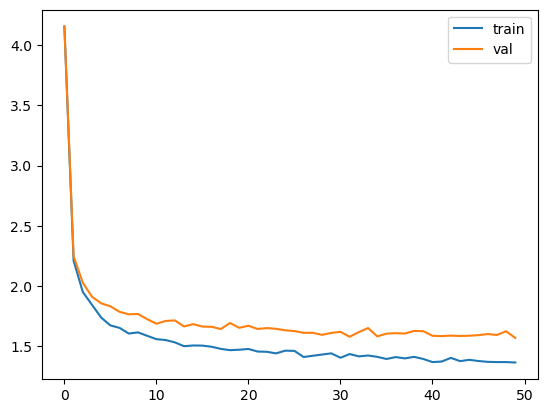

In [10]:
%%time

from datetime import datetime

llama = Llama(model_config)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, print_logs=True)

# Save
now = datetime.now()
model_name = f'./checkpoint/llama_L{model_config.n_layers}xH{model_config.n_heads}xC{model_config.max_seq_len}_{now.year}_{now.month}_{now.day}_{now.hour}_{now.minute}.pth'
torch.save({'model_state_dict': llama.state_dict()}, model_name)

## Generate

In [11]:
@torch.no_grad()
def generate(model : Llama, max_new_tokens = 10):
    model.eval()
    config = model.config
    max_new_tokens = model.config.max_seq_len if max_new_tokens > model.config.max_seq_len else max_new_tokens
    idx = torch.zeros(config.max_batch_size, 1).long()

    start_pos = 0
    for i in range(max_new_tokens):
        if i == 0:
            logits = model(idx)
        else:
            logits = model(idx[:, -1].unsqueeze(-1), start_pos)
            # logits = model(idx[:, -config.max_seq_len:], 0)
        
        last_time_step_logits = logits[:, -1, :]            # all the batches (1), last time step, all the logits
        p = F.softmax(last_time_step_logits, dim=-1)        # softmax to get probabilities
        idx_next = torch.multinomial(
            p, num_samples=1
        )                                                   # sample from the distribution to get the next token

        start_pos = idx.shape[-1]
        idx = torch.cat([idx, idx_next], dim=-1)            # append to the sequence
                    
    return [decode(x) for x in idx.tolist()]

In [12]:
import glob
import os

## Get lastest checkpoint
files = glob.glob('./checkpoint/*.pth')
files.sort(key=os.path.getmtime)
model_name = files[-1]

llama_infer = Llama(model_config)
llama_infer.load_state_dict(torch.load(model_name)['model_state_dict'])

Initialized RoPE with shape torch.Size([128, 64])
model params: 690113


<All keys matched successfully>

In [13]:
%%time

for s in generate(llama_infer, 100):
    print(s)


KING EDWARD IV:
And trust my fearful cry concule your loving
An great me her making our king;
And th

A say the people's cares: mine count ho!

First Citizen:
Here is the Tower.

CORIOLANUS:
Give head t


His like deservation our will
your traitor, to Coverbeats, if I say,
And stumble an one
One must st

LADY ANNE:
Sir, Corioli, awake but post.

SICINIUS:
I will bright will
Restard -time become in here.

RICHARD II:
What we this basend tell strike with the right.
Ance is the swalls worse Peter'd, she go

As that, and breder my proporture Heres as they liems imposes muster.

VOLUMNIA:
Then tell Richard! 

But etwo I up, sweet a Dive he Catesby,
Than I say, in behold round thee; my else.
O, who preventure

We married. What it subjects spur pale:
You then Juliet purly he discan encourteous lay
with thing; 

A thou for leave to for a gone: dear you the sted
it services in my are behold say.

Lady:
Then your

KING EDWARD IV:
Shall I, to avoide, and my lord man.

GLOUCESTER:
Then, God Saint